In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

# Estilo profesional
plt.rcParams['figure.facecolor'] = '#0f1117'
plt.rcParams['axes.facecolor']   = '#1a1d2e'
plt.rcParams['axes.labelcolor']  = 'white'
plt.rcParams['xtick.color']      = 'white'
plt.rcParams['ytick.color']      = 'white'
plt.rcParams['text.color']       = 'white'
plt.rcParams['grid.color']       = '#2d2d2d'
plt.rcParams['grid.alpha']       = 0.4
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False

# ✅ Rutas — usamos os.path.join para evitar problemas con espacios
PROJECT_ROOT = os.path.join(
    r"C:\Users\matup\OneDrive\Documentos",
    "sistema_de_Predicción_de_Fallos_en_Última Milla"
)

DATA_RAW     = os.path.join(PROJECT_ROOT, "data", "raw",
               "dataset_distribucion_nacional2.csv")
FIGURES_PATH = os.path.join(PROJECT_ROOT, "outputnts", "figures")
REPORTS_PATH = os.path.join(PROJECT_ROOT, "outputnts", "reports")

os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

# Verificar que existe
print("¿Existe el proyecto?", os.path.exists(PROJECT_ROOT))
print("¿Existe el CSV?     ", os.path.exists(DATA_RAW))

# ✅ Cargar datos
df = pd.read_csv(DATA_RAW)
df['fecha_envio'] = pd.to_datetime(df['fecha_envio'])
df['mes_nombre']  = df['fecha_envio'].dt.strftime('%Y-%m')
df['trimestre']   = df['fecha_envio'].dt.to_period('Q').astype(str)

print("\n✅ Datos cargados:", df.shape)
print("   Período:", df['fecha_envio'].min().date(),
      "→", df['fecha_envio'].max().date())

¿Existe el proyecto? True
¿Existe el CSV?      True

✅ Datos cargados: (500000, 25)
   Período: 2022-01-01 → 2024-12-31


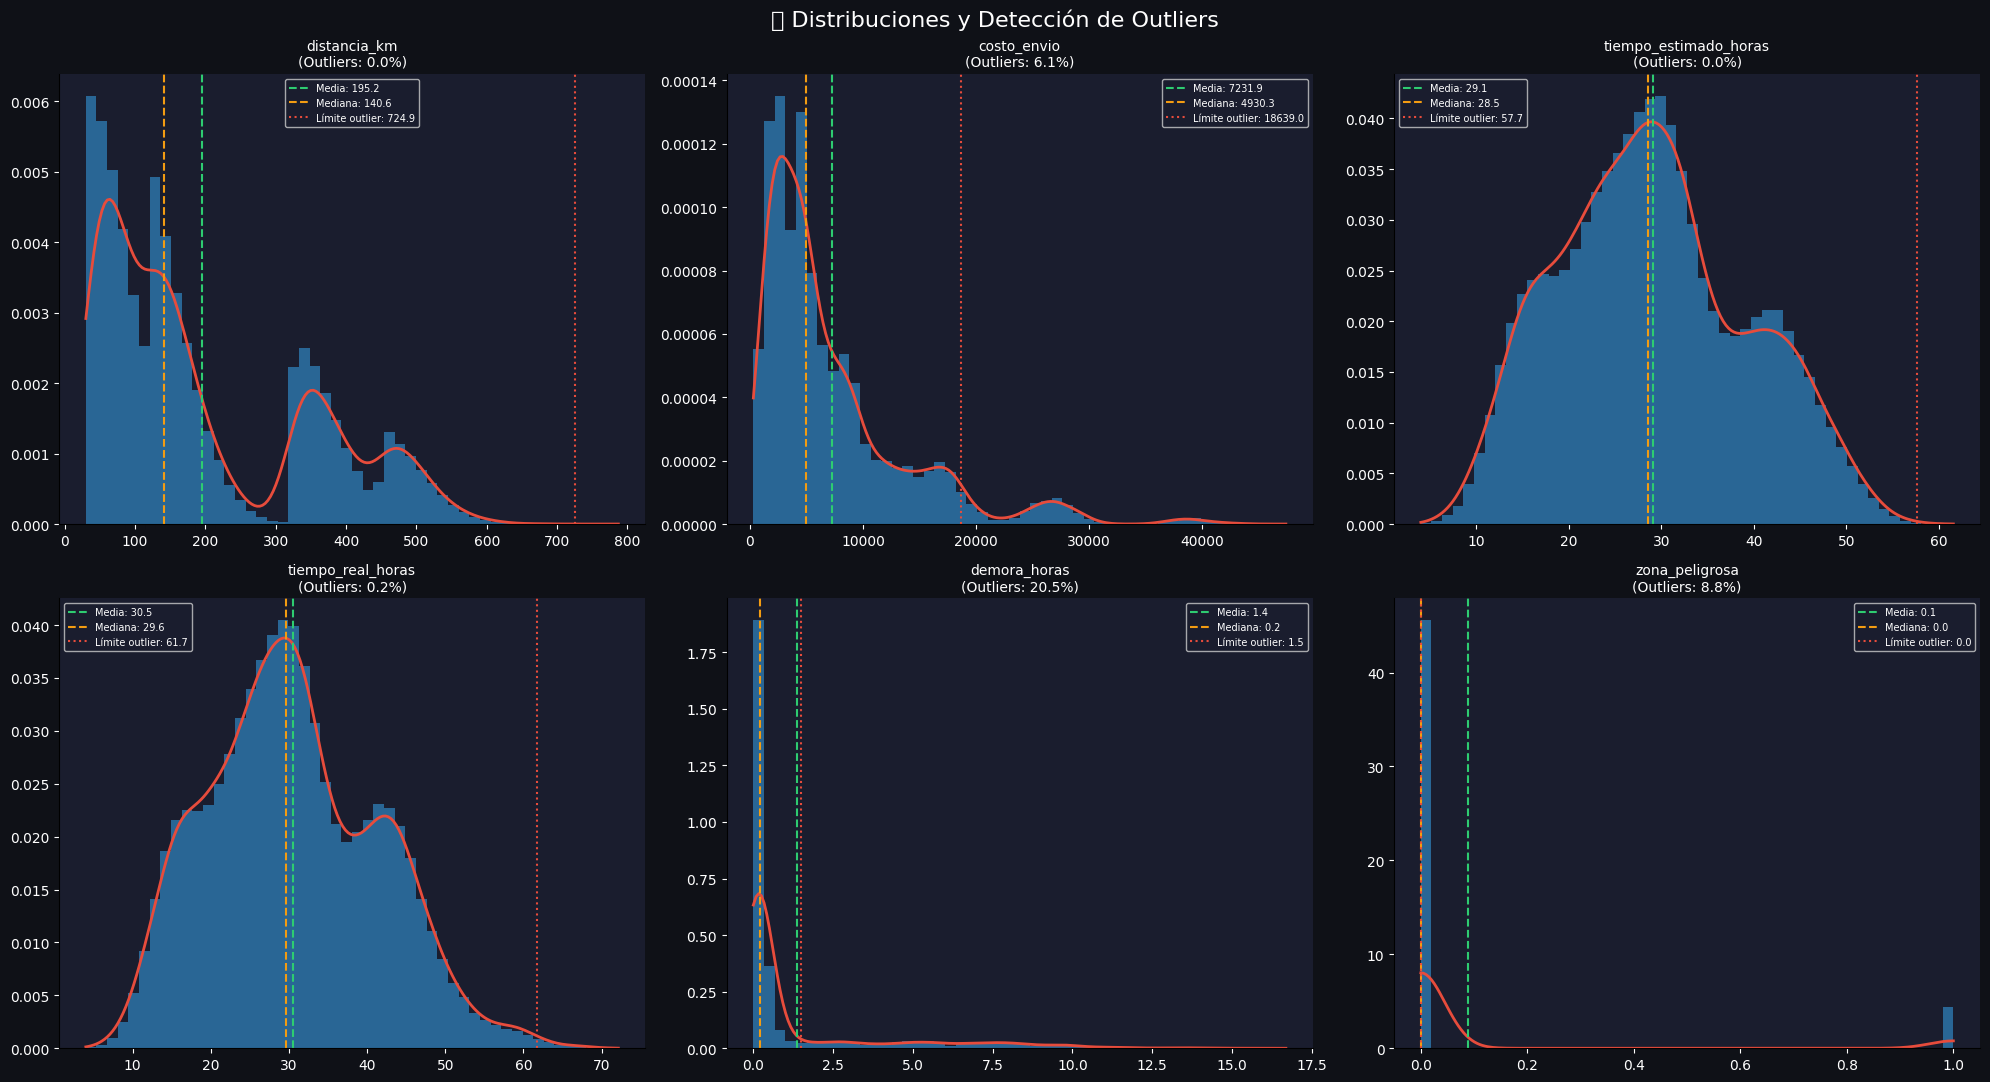

✅ Guardado: eda_avanzado_02_outliers.png


In [2]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle('📊 Distribuciones y Detección de Outliers', fontsize=16)

variables = ['distancia_km', 'costo_envio', 'tiempo_estimado_horas',
             'tiempo_real_horas', 'demora_horas', 'zona_peligrosa']

for i, var in enumerate(variables):
    if var not in df.columns:
        continue
    row, col = divmod(i, 3)
    ax = axes[row, col]
    data = df[var].dropna()

    # Histograma con KDE
    ax.hist(data, bins=50, color='#3498db', alpha=0.6,
            edgecolor='none', density=True)

    # KDE
    try:
        kde_x = np.linspace(data.min(), data.max(), 200)
        kde   = stats.gaussian_kde(data.sample(min(10000, len(data))))
        ax.plot(kde_x, kde(kde_x), color='#e74c3c', linewidth=2)
    except Exception:
        pass

    # Líneas de percentiles
    p25, p75 = data.quantile(0.25), data.quantile(0.75)
    iqr       = p75 - p25
    limite_sup = p75 + 1.5 * iqr

    ax.axvline(data.mean(),   color='#2ecc71', linestyle='--',
               linewidth=1.5, label=f'Media: {data.mean():.1f}')
    ax.axvline(data.median(), color='#f39c12', linestyle='--',
               linewidth=1.5, label=f'Mediana: {data.median():.1f}')
    ax.axvline(limite_sup,    color='#e74c3c', linestyle=':',
               linewidth=1.5, label=f'Límite outlier: {limite_sup:.1f}')

    outliers_pct = (data > limite_sup).mean() * 100
    ax.set_title(f'{var}\n(Outliers: {outliers_pct:.1f}%)', fontsize=10)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eda_avanzado_02_outliers.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eda_avanzado_02_outliers.png")

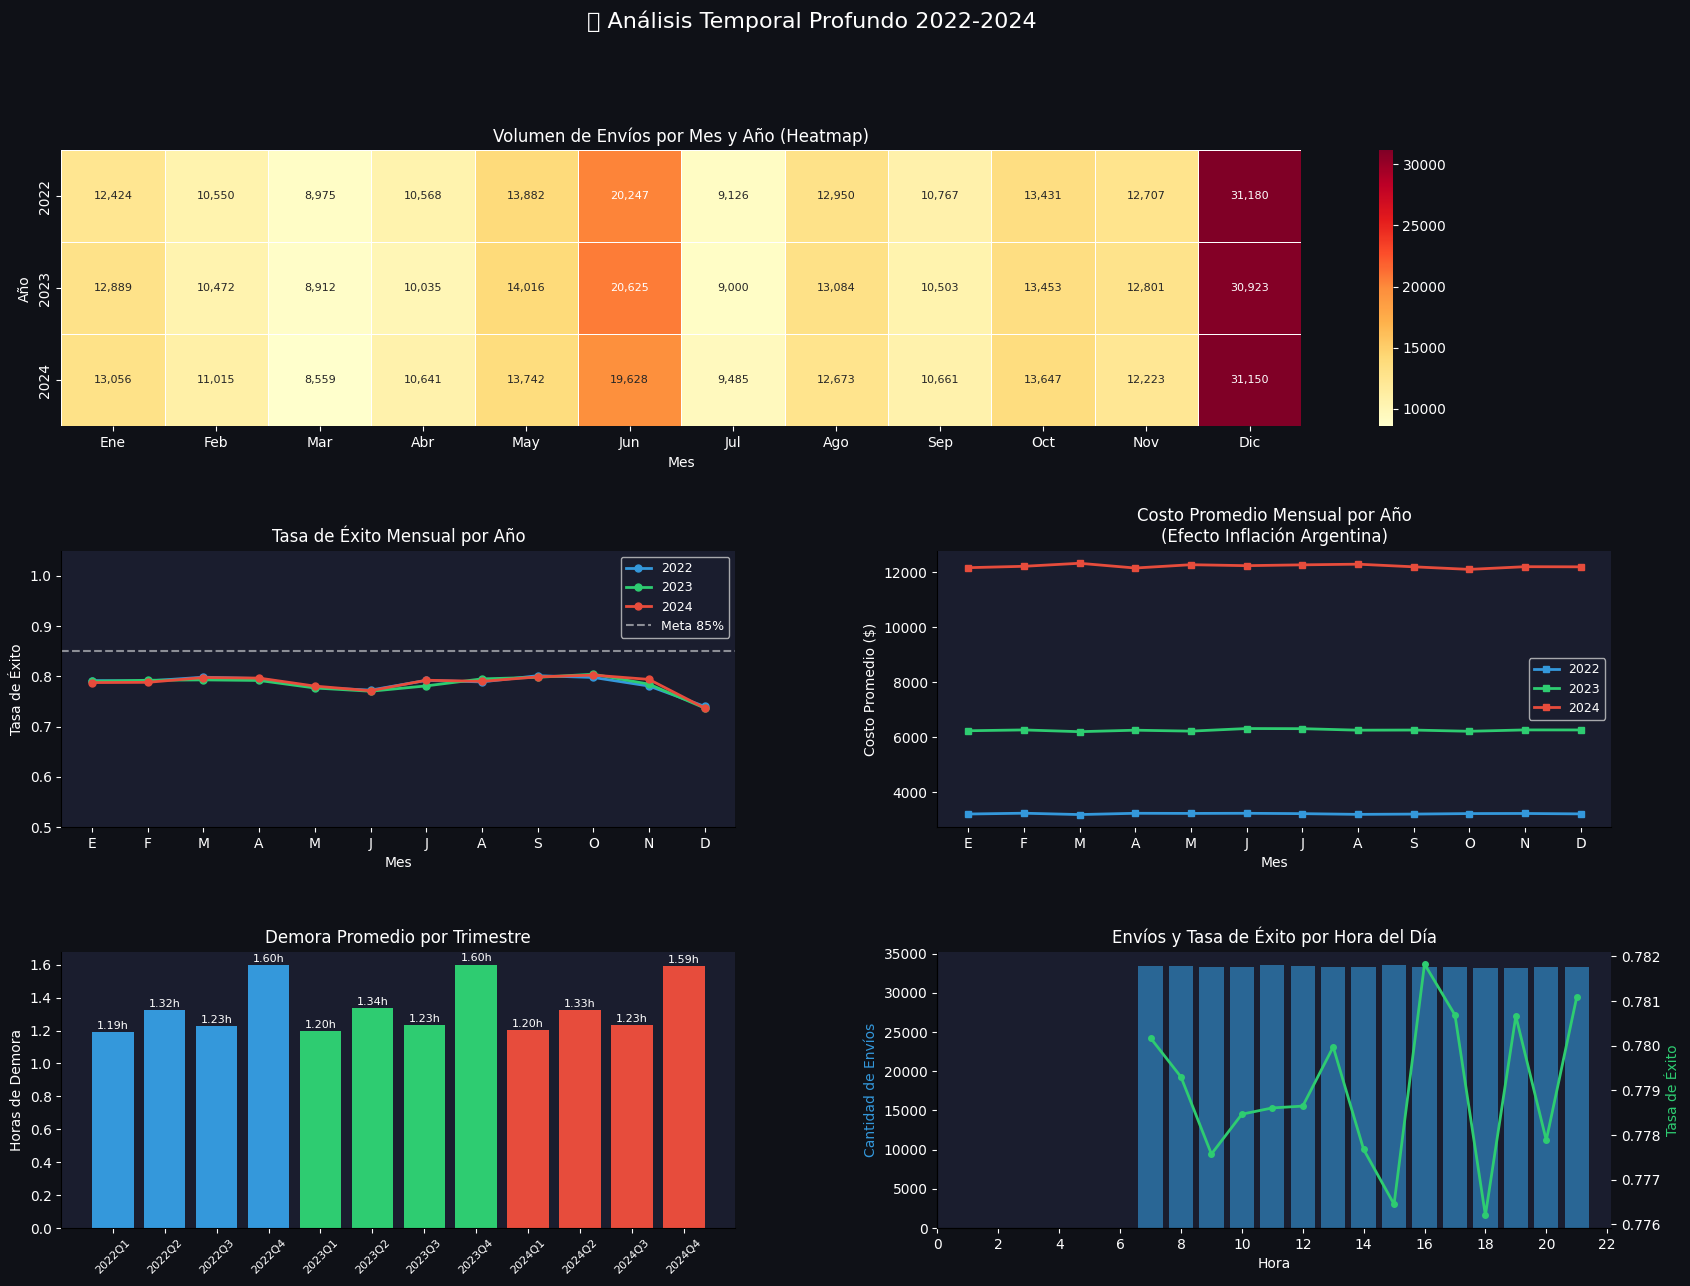

✅ Guardado: eda_avanzado_03_temporal.png


In [3]:
fig = plt.figure(figsize=(20, 14))
fig.suptitle('📅 Análisis Temporal Profundo 2022-2024', fontsize=16)
gs  = gridspec.GridSpec(3, 2, figure=fig, hspace=0.45, wspace=0.3)

# ── 1. Heatmap envíos por mes y año ──────────────────────
ax1 = fig.add_subplot(gs[0, :])
pivot_tiempo = df.groupby(['anio', 'mes']).size().unstack(fill_value=0)
sns.heatmap(pivot_tiempo, annot=True, fmt=',', cmap='YlOrRd',
            ax=ax1, linewidths=0.5,
            xticklabels=['Ene','Feb','Mar','Abr','May','Jun',
                          'Jul','Ago','Sep','Oct','Nov','Dic'],
            annot_kws={'size': 8})
ax1.set_title('Volumen de Envíos por Mes y Año (Heatmap)', fontsize=12)
ax1.set_xlabel('Mes')
ax1.set_ylabel('Año')

# ── 2. Tasa éxito mensual por año ────────────────────────
ax2 = fig.add_subplot(gs[1, 0])
colores_anio = {2022: '#3498db', 2023: '#2ecc71', 2024: '#e74c3c'}
for anio in df['anio'].unique():
    datos_anio = df[df['anio'] == anio]
    tasa_mes   = datos_anio.groupby('mes')['entrega_exitosa'].mean()
    ax2.plot(tasa_mes.index, tasa_mes.values,
             marker='o', linewidth=2, markersize=5,
             label=str(anio), color=colores_anio.get(anio, 'white'))
ax2.axhline(y=0.85, color='white', linestyle='--', alpha=0.5, label='Meta 85%')
ax2.set_title('Tasa de Éxito Mensual por Año')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Tasa de Éxito')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['E','F','M','A','M','J','J','A','S','O','N','D'])
ax2.legend(fontsize=9)
ax2.set_ylim(0.5, 1.05)

# ── 3. Costo promedio mensual por año ────────────────────
ax3 = fig.add_subplot(gs[1, 1])
for anio in df['anio'].unique():
    datos_anio = df[df['anio'] == anio]
    costo_mes  = datos_anio.groupby('mes')['costo_envio'].mean()
    ax3.plot(costo_mes.index, costo_mes.values,
             marker='s', linewidth=2, markersize=5,
             label=str(anio), color=colores_anio.get(anio, 'white'))
ax3.set_title('Costo Promedio Mensual por Año\n(Efecto Inflación Argentina)')
ax3.set_xlabel('Mes')
ax3.set_ylabel('Costo Promedio ($)')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['E','F','M','A','M','J','J','A','S','O','N','D'])
ax3.legend(fontsize=9)

# ── 4. Demora promedio por trimestre ─────────────────────
ax4 = fig.add_subplot(gs[2, 0])
demora_trim = df.groupby('trimestre')['demora_horas'].mean().sort_index()
colores_trim = ['#3498db' if '2022' in t else '#2ecc71'
                if '2023' in t else '#e74c3c' for t in demora_trim.index]
bars = ax4.bar(range(len(demora_trim)), demora_trim.values, color=colores_trim)
ax4.set_xticks(range(len(demora_trim)))
ax4.set_xticklabels(demora_trim.index, rotation=45, fontsize=8)
ax4.set_title('Demora Promedio por Trimestre')
ax4.set_ylabel('Horas de Demora')
for bar, val in zip(bars, demora_trim.values):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.02,
             f'{val:.2f}h', ha='center', fontsize=8)

# ── 5. Volumen por hora del día ───────────────────────────
ax5 = fig.add_subplot(gs[2, 1])
df['hora'] = df['fecha_envio'].dt.hour
envios_hora = df.groupby('hora').size()
tasa_hora   = df.groupby('hora')['entrega_exitosa'].mean()

ax5_twin = ax5.twinx()
ax5.bar(envios_hora.index, envios_hora.values,
        color='#3498db', alpha=0.6, label='Volumen')
ax5_twin.plot(tasa_hora.index, tasa_hora.values,
              color='#2ecc71', linewidth=2,
              marker='o', markersize=4, label='Tasa Éxito')
ax5.set_title('Envíos y Tasa de Éxito por Hora del Día')
ax5.set_xlabel('Hora')
ax5.set_ylabel('Cantidad de Envíos', color='#3498db')
ax5_twin.set_ylabel('Tasa de Éxito', color='#2ecc71')
ax5.set_xticks(range(0, 24, 2))

plt.savefig(os.path.join(FIGURES_PATH, "eda_avanzado_03_temporal.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eda_avanzado_03_temporal.png")

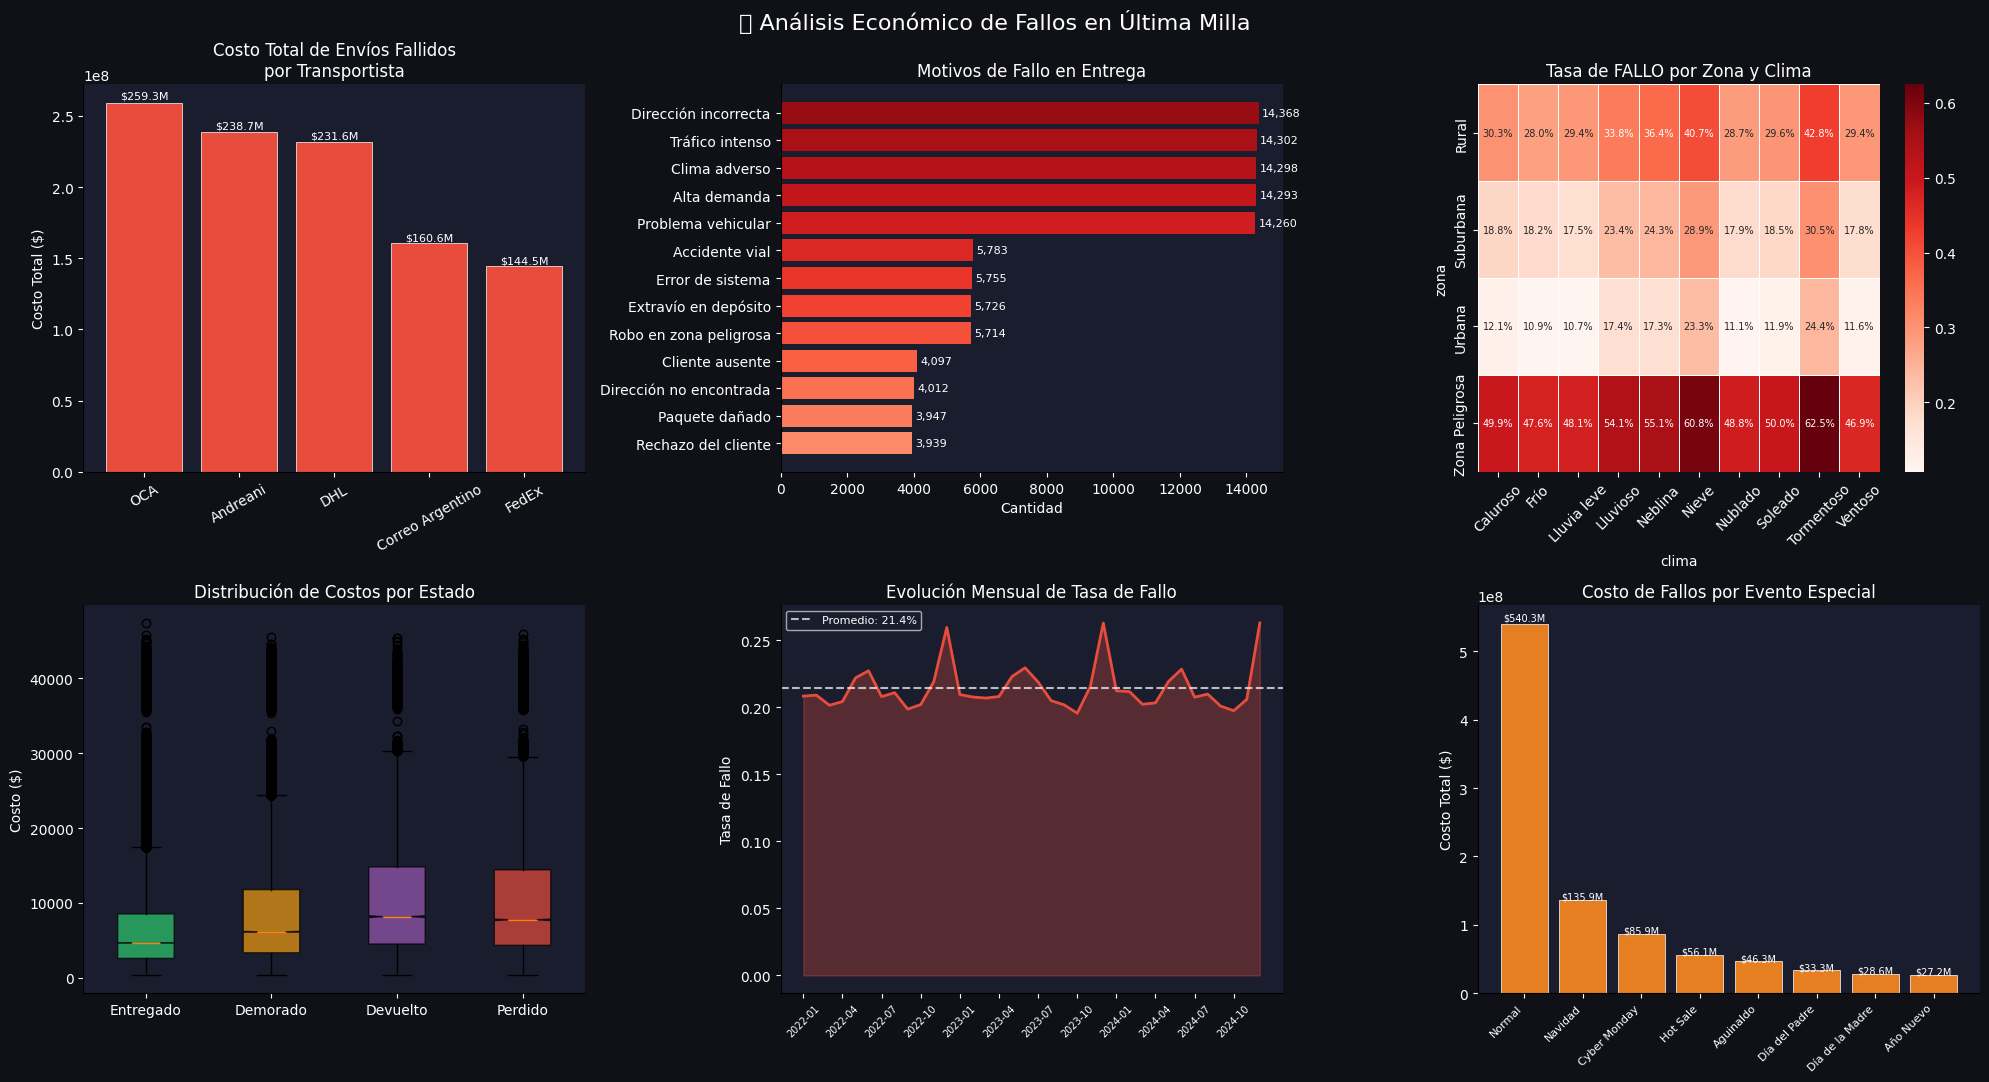

✅ Guardado: eda_avanzado_04_fallos_economico.png


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle('💸 Análisis Económico de Fallos en Última Milla', fontsize=16)

# ── 1. Costo de fallos por transportista ─────────────────
costo_fallos_trans = df[df['entrega_exitosa'] == 0].groupby(
    'transportista')['costo_envio'].sum().sort_values(ascending=False)
axes[0,0].bar(costo_fallos_trans.index, costo_fallos_trans.values,
              color='#e74c3c', edgecolor='white', linewidth=0.5)
axes[0,0].set_title('Costo Total de Envíos Fallidos\npor Transportista')
axes[0,0].set_ylabel('Costo Total ($)')
axes[0,0].tick_params(axis='x', rotation=30)
for i, val in enumerate(costo_fallos_trans.values):
    axes[0,0].text(i, val + val*0.01, f'${val/1e6:.1f}M',
                   ha='center', fontsize=8)

# ── 2. Motivos de fallo ───────────────────────────────────
if 'motivo_fallo' in df.columns:
    motivos = df['motivo_fallo'].dropna().value_counts()
    colores_m = plt.cm.Reds(np.linspace(0.4, 0.9, len(motivos)))
    axes[0,1].barh(motivos.index[::-1], motivos.values[::-1], color=colores_m)
    axes[0,1].set_title('Motivos de Fallo en Entrega')
    axes[0,1].set_xlabel('Cantidad')
    for i, val in enumerate(motivos.values[::-1]):
        axes[0,1].text(val + 100, i, f'{val:,}', va='center', fontsize=8)

# ── 3. Tasa fallo por zona peligrosa y clima ──────────────
pivot_fallo = df.groupby(['zona', 'clima'])['entrega_exitosa'].mean().unstack()
pivot_fallo = 1 - pivot_fallo
sns.heatmap(pivot_fallo.fillna(0), annot=True, fmt='.1%',
            cmap='Reds', ax=axes[0,2], linewidths=0.5,
            annot_kws={'size': 7})
axes[0,2].set_title('Tasa de FALLO por Zona y Clima')
axes[0,2].tick_params(axis='x', rotation=45)

# ── 4. Boxplot costo por estado ───────────────────────────
estados_orden = ['Entregado', 'Demorado', 'Devuelto', 'Perdido']
colores_box   = ['#2ecc71', '#f39c12', '#9b59b6', '#e74c3c']
data_box      = [df[df['estado'] == e]['costo_envio'].values
                 for e in estados_orden if e in df['estado'].unique()]
bp = axes[1,0].boxplot(data_box, labels=estados_orden,
                        patch_artist=True, notch=True)
for patch, color in zip(bp['boxes'], colores_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1,0].set_title('Distribución de Costos por Estado')
axes[1,0].set_ylabel('Costo ($)')

# ── 5. Evolución tasa fallo mensual ──────────────────────
tasa_fallo_mensual = df.groupby('mes_nombre').apply(
    lambda x: (x['entrega_exitosa'] == 0).mean()
).reset_index()
tasa_fallo_mensual.columns = ['mes', 'tasa_fallo']

axes[1,1].fill_between(range(len(tasa_fallo_mensual)),
                        tasa_fallo_mensual['tasa_fallo'],
                        alpha=0.3, color='#e74c3c')
axes[1,1].plot(range(len(tasa_fallo_mensual)),
               tasa_fallo_mensual['tasa_fallo'],
               color='#e74c3c', linewidth=2)
axes[1,1].axhline(y=tasa_fallo_mensual['tasa_fallo'].mean(),
                   color='white', linestyle='--', alpha=0.7,
                   label=f"Promedio: {tasa_fallo_mensual['tasa_fallo'].mean():.1%}")
axes[1,1].set_title('Evolución Mensual de Tasa de Fallo')
axes[1,1].set_xticks(range(0, len(tasa_fallo_mensual), 3))
axes[1,1].set_xticklabels(
    tasa_fallo_mensual['mes'].iloc[::3], rotation=45, fontsize=7)
axes[1,1].set_ylabel('Tasa de Fallo')
axes[1,1].legend(fontsize=8)

# ── 6. Impacto económico por evento ──────────────────────
costo_evento = df[df['entrega_exitosa'] == 0].groupby(
    'evento_especial')['costo_envio'].sum().sort_values(ascending=False).head(8)
axes[1,2].bar(range(len(costo_evento)), costo_evento.values,
              color='#e67e22', edgecolor='white', linewidth=0.5)
axes[1,2].set_xticks(range(len(costo_evento)))
axes[1,2].set_xticklabels(costo_evento.index, rotation=45,
                            ha='right', fontsize=8)
axes[1,2].set_title('Costo de Fallos por Evento Especial')
axes[1,2].set_ylabel('Costo Total ($)')
for i, val in enumerate(costo_evento.values):
    axes[1,2].text(i, val + val*0.01, f'${val/1e6:.1f}M',
                   ha='center', fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eda_avanzado_04_fallos_economico.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eda_avanzado_04_fallos_economico.png")

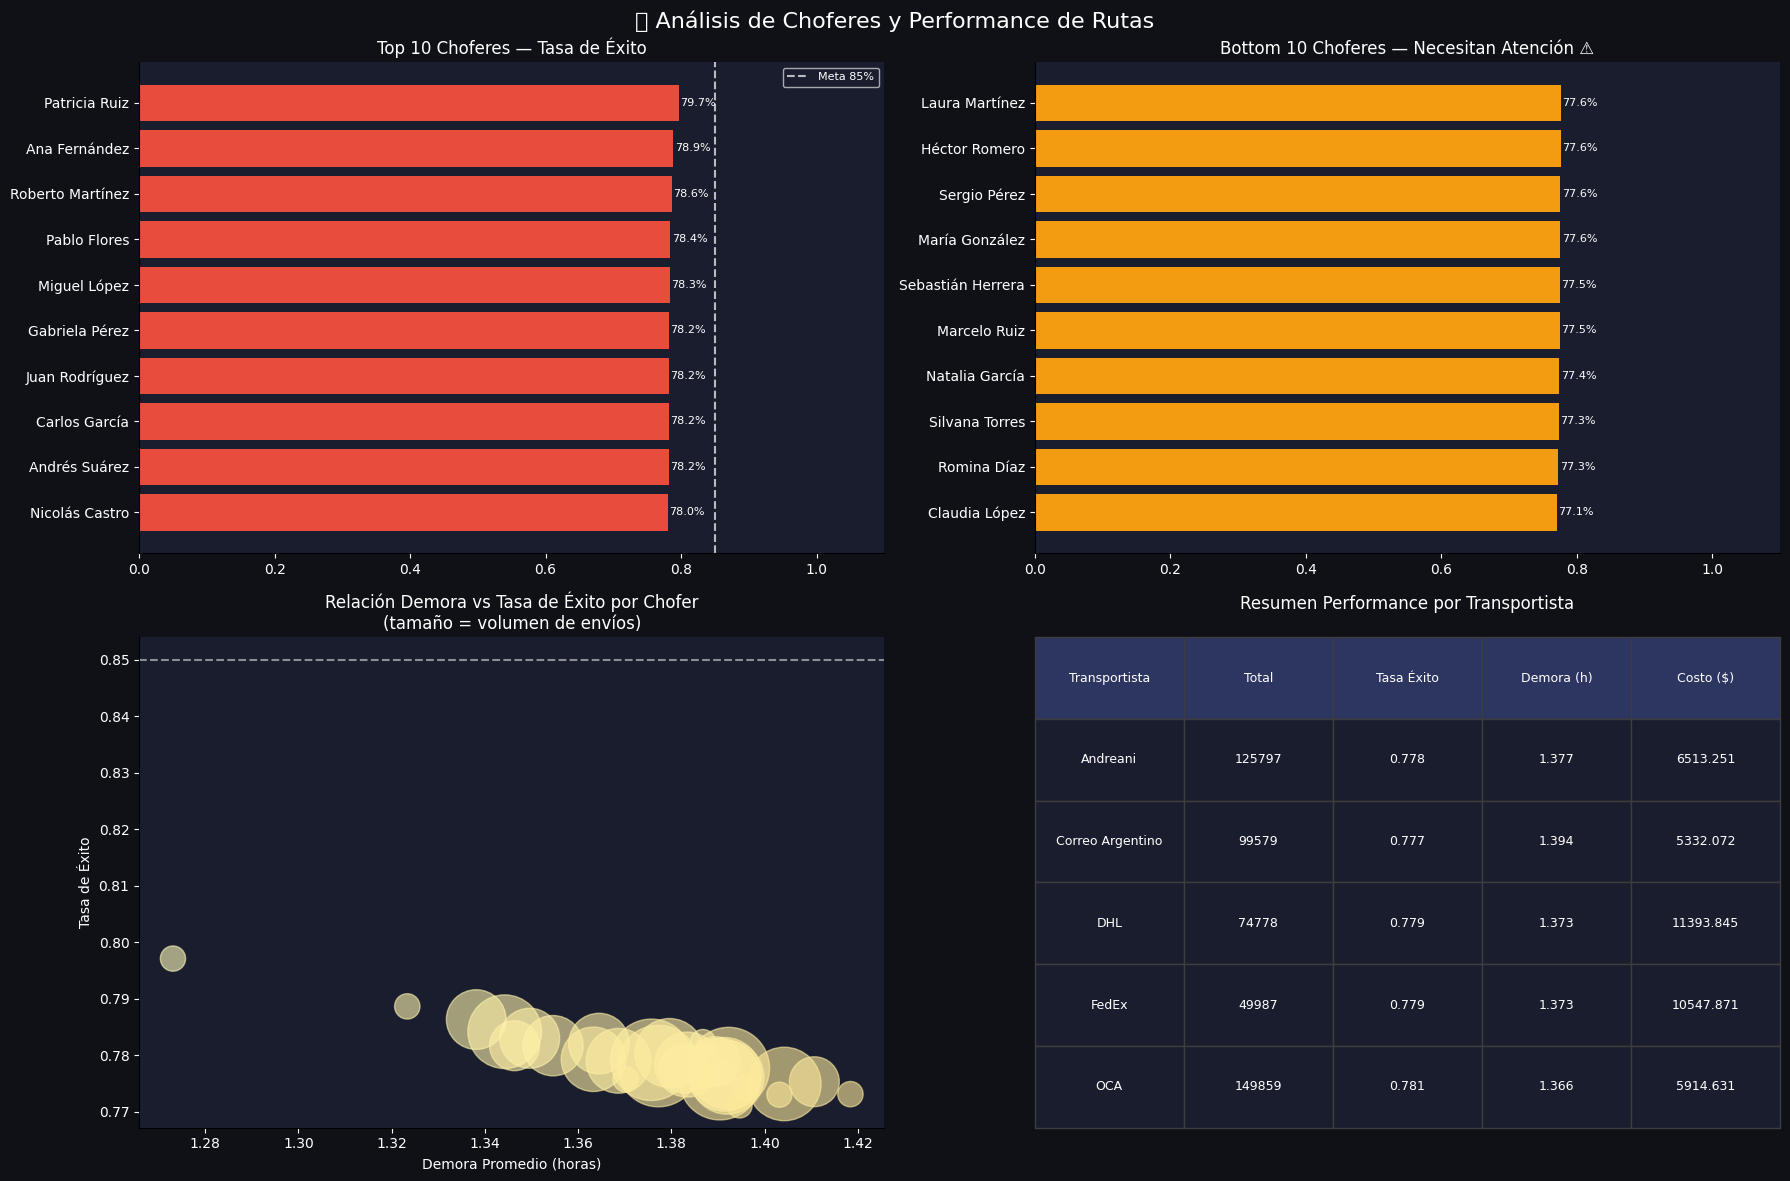

✅ Guardado: eda_avanzado_05_choferes.png


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('👤 Análisis de Choferes y Performance de Rutas', fontsize=16)

# ── 1. Top 10 choferes por tasa de éxito ─────────────────
if 'chofer' in df.columns:
    choferes_stats = df.groupby('chofer').agg(
        total=('shipment_id', 'count'),
        tasa=('entrega_exitosa', 'mean'),
        demora=('demora_horas', 'mean'),
        costo=('costo_envio', 'mean')
    ).query('total >= 100').sort_values('tasa', ascending=False)

    top10 = choferes_stats.head(10)
    colores_ch = ['#2ecc71' if t > 0.90 else '#f39c12'
                  if t > 0.80 else '#e74c3c' for t in top10['tasa']]
    bars = axes[0,0].barh(top10.index[::-1], top10['tasa'].values[::-1],
                           color=colores_ch[::-1])
    axes[0,0].axvline(x=0.85, color='white', linestyle='--',
                       alpha=0.7, label='Meta 85%')
    for bar, val in zip(bars, top10['tasa'].values[::-1]):
        axes[0,0].text(val + 0.002, bar.get_y() + bar.get_height()/2,
                       f'{val:.1%}', va='center', fontsize=8)
    axes[0,0].set_title('Top 10 Choferes — Tasa de Éxito')
    axes[0,0].set_xlim(0, 1.1)
    axes[0,0].legend(fontsize=8)

    # ── 2. Bottom 10 choferes ─────────────────────────────
    bottom10 = choferes_stats.tail(10)
    colores_b = ['#e74c3c' if t < 0.75 else '#f39c12' for t in bottom10['tasa']]
    bars2 = axes[0,1].barh(bottom10.index[::-1], bottom10['tasa'].values[::-1],
                             color=colores_b[::-1])
    for bar, val in zip(bars2, bottom10['tasa'].values[::-1]):
        axes[0,1].text(val + 0.002, bar.get_y() + bar.get_height()/2,
                       f'{val:.1%}', va='center', fontsize=8)
    axes[0,1].set_title('Bottom 10 Choferes — Necesitan Atención ⚠️')
    axes[0,1].set_xlim(0, 1.1)

    # ── 3. Scatter tasa vs demora por chofer ──────────────
    axes[1,0].scatter(choferes_stats['demora'],
                      choferes_stats['tasa'],
                      alpha=0.6, s=choferes_stats['total']/10,
                      c=choferes_stats['tasa'],
                      cmap='RdYlGn', vmin=0.6, vmax=1.0)
    axes[1,0].axhline(y=0.85, color='white', linestyle='--', alpha=0.5)
    axes[1,0].set_xlabel('Demora Promedio (horas)')
    axes[1,0].set_ylabel('Tasa de Éxito')
    axes[1,0].set_title('Relación Demora vs Tasa de Éxito por Chofer\n(tamaño = volumen de envíos)')

    # ── 4. Performance por transportista y chofer ─────────
    trans_perf = df.groupby('transportista').agg(
        total=('shipment_id', 'count'),
        tasa=('entrega_exitosa', 'mean'),
        demora=('demora_horas', 'mean'),
        costo=('costo_envio', 'mean')
    ).round(3)

    axes[1,1].axis('off')
    tabla = axes[1,1].table(
        cellText=trans_perf.reset_index().values,
        colLabels=['Transportista', 'Total', 'Tasa Éxito', 'Demora (h)', 'Costo ($)'],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(9)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_facecolor('#1a1d2e' if row > 0 else '#2d3561')
        cell.set_text_props(color='white')
        cell.set_edgecolor('#3d3d3d')
    axes[1,1].set_title('Resumen Performance por Transportista', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "eda_avanzado_05_choferes.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: eda_avanzado_05_choferes.png")

In [6]:
print("💾 Generando reporte Excel completo...")

excel_path = os.path.join(REPORTS_PATH, "eda_avanzado_reporte.xlsx")

with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:

    # Hoja 1 — KPIs generales
    kpis = pd.DataFrame({
        'KPI': ['Total Envíos', 'Tasa Éxito Global', 'Total Fallidos',
                'Tasa Fallo', 'Costo Promedio', 'Demora Promedio'],
        'Valor': [
            f"{len(df):,}",
            f"{df['entrega_exitosa'].mean():.2%}",
            f"{(df['entrega_exitosa']==0).sum():,}",
            f"{(df['entrega_exitosa']==0).mean():.2%}",
            f"${df['costo_envio'].mean():,.0f}",
            f"{df['demora_horas'].mean():.2f} hs"
        ]
    })
    kpis.to_excel(writer, sheet_name='KPIs', index=False)

    # Hoja 2 — Por transportista
    df.groupby('transportista').agg(
        Total=('shipment_id', 'count'),
        Tasa_Exito=('entrega_exitosa', 'mean'),
        Costo_Promedio=('costo_envio', 'mean'),
        Demora_Promedio=('demora_horas', 'mean')
    ).round(3).to_excel(writer, sheet_name='Por_Transportista')

    # Hoja 3 — Por provincia
    df.groupby('provincia').agg(
        Total=('shipment_id', 'count'),
        Tasa_Exito=('entrega_exitosa', 'mean'),
        Costo_Promedio=('costo_envio', 'mean'),
        Demora_Promedio=('demora_horas', 'mean')
    ).round(3).to_excel(writer, sheet_name='Por_Provincia')

    # Hoja 4 — Por evento especial
    df.groupby('evento_especial').agg(
        Total=('shipment_id', 'count'),
        Tasa_Exito=('entrega_exitosa', 'mean'),
        Costo_Promedio=('costo_envio', 'mean'),
        Demora_Promedio=('demora_horas', 'mean')
    ).round(3).to_excel(writer, sheet_name='Por_Evento')

    # Hoja 5 — Por clima
    df.groupby('clima').agg(
        Total=('shipment_id', 'count'),
        Tasa_Exito=('entrega_exitosa', 'mean'),
        Demora_Promedio=('demora_horas', 'mean')
    ).round(3).to_excel(writer, sheet_name='Por_Clima')

    # Hoja 6 — Por zona
    df.groupby('zona').agg(
        Total=('shipment_id', 'count'),
        Tasa_Exito=('entrega_exitosa', 'mean'),
        Costo_Promedio=('costo_envio', 'mean'),
        Demora_Promedio=('demora_horas', 'mean')
    ).round(3).to_excel(writer, sheet_name='Por_Zona')

print(f"✅ Reporte Excel guardado en:")
print(f"   {excel_path}")
print(f"\n📊 Hojas generadas:")
print("   → KPIs")
print("   → Por_Transportista")
print("   → Por_Provincia")
print("   → Por_Evento")
print("   → Por_Clima")
print("   → Por_Zona")

💾 Generando reporte Excel completo...
✅ Reporte Excel guardado en:
   C:\Users\matup\OneDrive\Documentos\sistema_de_Predicción_de_Fallos_en_Última Milla\outputnts\reports\eda_avanzado_reporte.xlsx

📊 Hojas generadas:
   → KPIs
   → Por_Transportista
   → Por_Provincia
   → Por_Evento
   → Por_Clima
   → Por_Zona


In [8]:
print("\n" + "=" * 60)
print("✅ EDA AVANZADO COMPLETADO")
print("=" * 60)

print(f"""
📁 ARCHIVOS GENERADOS:

   Figuras:
   → eda_avanzado_01_correlaciones.png
   → eda_avanzado_02_outliers.png
   → eda_avanzado_03_temporal.png
   → eda_avanzado_04_fallos_economico.png
   → eda_avanzado_05_choferes.png

   Reportes:
   → eda_avanzado_reporte.xlsx (6 hojas)

🎯 PRÓXIMO PASO:
   02_limpieza_y_transformacion.ipynb
""")


✅ EDA AVANZADO COMPLETADO

📁 ARCHIVOS GENERADOS:

   Figuras:
   → eda_avanzado_01_correlaciones.png
   → eda_avanzado_02_outliers.png
   → eda_avanzado_03_temporal.png
   → eda_avanzado_04_fallos_economico.png
   → eda_avanzado_05_choferes.png

   Reportes:
   → eda_avanzado_reporte.xlsx (6 hojas)

🎯 PRÓXIMO PASO:
   02_limpieza_y_transformacion.ipynb

